In [41]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.dates as mdates

In [ ]:
'''If executed in Google Colab, uncomment the following lines'''
#from google.colab import drive
#drive.mount('/content/drive')

#import os
#os.chdir('/content/drive/MyDrive/LLM_CreditorRRPrediction')

In [ ]:
dealer_df = pd.read_csv('dealer/dealer_data_llm_output.csv', delimiter= '|')

In [ ]:
presentation_labels = ['negative_sentiment', 'positive_sentiment', 'uncertainty', 'optimistic', 'pessimistic', 'vagueness', 'language_accessibility_presentation',
              'liquidity_position', 'debt_leverage_stress', 'operational_trends', 'industry_positioning', 'asset_quality', 'recovery_strategies', 'legal_issues','macroeconomic']

qna_labels = ['analyst_concerns', 'responsiveness', 'confidence', 'evasiveness', 'depth', 'analyst_satisfaction', 'language_accessibility_qna']

qna_mgmt = ['responsiveness', 'confidence', 'depth', 'evasiveness', 'language_accessibility_qna']
qna_analysts = ['analyst_concerns', 'analyst_satisfaction']

emotions = [
        'admiration', 
        #'amusement', 
        'anger', 
        'annoyance', 
        'approval', 
        'caring', 
        'confusion', 
        'curiosity', 
        'desire',
        'disappointment', 
        'disapproval', 
        #'disgust', 
        'embarrassment', 
        'excitement', 
        'fear', 
        #'gratitude', 
        #'grief',
        'joy', 
        #'love', 
        'nervousness', 
        'optimism', 
        'pride', 
        'realization', 
        'relief', 
        'remorse', 
        'sadness', 
        'surprise'
    ]

analyst_emotions = []
for i in emotions:
    analyst_emotions.append(i + '_analysts')

macro_industry = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 'Consumer Discretionary', 'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

primary_dealer_features = [
    'TimeToMaturity', 'TimeSinceOffering', 'Offering_amount',
       'SinkingFund', 'BOND_COUPON', 'IQ_CDS_availability',
        'AvgTransVol', 'TotalVolume', 'TRADES_VOL',
       'EquityValue', 'DefaultBarrier2', 'LTDIssuance2', 'Intangibility', 'Receivables1',
       'IndDis1', 'IndDis2'
]

In [16]:
def create_colored_chart(model, type):

    # Filter significant features
    significant_features = model.pvalues[model.pvalues < 0.05].index
    importances = model.params[significant_features]  # Only significant features
    importances = importances[1:]

    # Sort importances by their absolute value, and select the top 10
    top_15_importances = importances.abs().sort_values(ascending=False).head(15)
    importances = importances[top_15_importances.index]
    importances = importances.sort_values()  # Sort the values for better visualization

    # Define emotion types (assuming the feature names match these emotion labels)
    emotion_types = {
        'relief': 'positive',
        'remorse': 'negative',
        'nervousness': 'negative',
        'desire': 'positive',
        'fear': 'strong_negative',
        'excitement': 'positive',
        'confusion': 'negative',
        'pride': 'positive',
        'annoyance': 'negative',
        'gratitude': 'positive',
        'anger': 'strong_negative',
        'optimism': 'positive',
        'sadness': 'negative', 
        'approval': 'positive',
        'caring': 'positive',
        'disappointment': 'negative',
        'curiosity': 'positive',
        'surprise': 'positive',
        'admiration': 'positive',
        'embarrassment': 'negative',
        'realization': 'positive',
        'disapproval': 'negative',
        'joy': 'positive',
        'relief_analysts': 'positive',
        'remorse_analysts': 'negative',
        'nervousness_analysts': 'negative',
        'desire_analysts': 'positive',
        'fear_analysts': 'strong_negative',
        'excitement_analysts': 'positive',
        'confusion_analysts': 'negative',
        'pride_analysts': 'positive',
        'annoyance_analysts': 'negative',
        'gratitude_analysts': 'positive',
        'anger_analysts': 'strong_negative',
        'optimism_analysts': 'positive',
        'sadness_analysts': 'negative',
        'approval_analysts': 'positive',
        'caring_analysts': 'positive',
        'disappointment_analysts': 'negative',
        'curiosity_analysts': 'positive',
        'surprise_analysts': 'positive',
        'admiration_analysts': 'positive',
        'embarrassment_analysts': 'negative',
        'realization_analysts': 'positive',
        'disapproval_analysts': 'negative',
        'joy_analysts': 'positive'
    }

    # Map colors to each emotion type
    color_mapping = {
        'positive': 'green',
        'strong_negative': 'red',
        'negative': 'gray',
    }

    # Apply the color mapping to the top 12 significant features
    colors = []
    for feature in importances.index:
        if feature in macro_industry or feature in primary_dealer_features:
            colors.append('blue')
        elif feature in presentation_labels or feature in qna_labels:
            colors.append('orange')
        elif feature in emotion_types:
            colors.append(color_mapping[emotion_types[feature]])
        else:
            colors.append('purple')  # Default for unknown features

    # Create a horizontal bar plot for the top 12 significant features
    plt.figure(figsize=(10, 5))
    plt.barh(importances.index, importances.values, color=colors)

    # add std errors
    plt.errorbar(importances, importances.index, xerr=model.bse[1:][importances.index], fmt='|', color='black')

    # Add labels and title
    plt.xlabel('Impact')
    plt.ylabel('Features')
    plt.title('Significant Features and their Impact')

    if type == 'Management Emotions' or type == 'Analyst Emotions' or type == 'All Emotions':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='gray'), plt.Rectangle((0, 0), 1, 1, color='red')
        ]
        labels = [
                'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion'
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'All Earnings call':
        # Create a custom legend
        handles = [
            #plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='orange'),
            plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='gray'), plt.Rectangle((0, 0), 1, 1, color='red')
        ]
        labels = [
                #'Financial Data', 
                'LLM Labels', 
                'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion'
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'Financial Data & Presentation Labels' or type == 'Financial Data & Q&A Labels' or type == 'Financial Data 1&2 & LLM Labels':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='orange'),
        ]
        labels = [
                'Financial Data', 
                'LLM Labels', 
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'Financial Data & All Emotions' or type == 'Financial Data & Management Emotions' or type == 'Financial Data & Analyst Emotions':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='gray'), plt.Rectangle((0, 0), 1, 1, color='red')
        ]
        labels = [
                'Financial Data', 
                'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion'
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'Financial Data & All Earnings call':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='orange'),
            plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='gray'), plt.Rectangle((0, 0), 1, 1, color='red')
        ]
        labels = [
                'Financial Data', 
                'LLM Labels', 
                'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion'
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'New Metrics':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='purple'),
        ]
        labels = [
                'Financial Data', 
                'New Metrics',
                ]
        # Add the legend
        plt.legend(handles, labels)

    # Show the plot
    return plt.show()


def create_significant_chart(model):

    # select significant features
    model.significance = model.pvalues[model.pvalues < 0.05].index

    # build a graph to show the importance of each feature
    importances = model.params[1:]
    importances = importances.sort_values()

    # Sort the importance values based on absolute values, not just positive or negative
    top_10_importances = importances.abs().sort_values(ascending=False).head(10)

    # reduce importances to only the top 10
    importances = importances[top_10_importances.index]
    importances = importances.sort_values()

    # color significant features 0/150/130 and others in grey
    colors = ['#009682' if feature in model.significance else 'grey' for feature in importances.index]

    plt.figure(figsize=(10, 5))
    plt.barh(importances.index, importances.values, color=colors)

    # add std errors
    plt.errorbar(importances, importances.index, xerr=model.bse[1:][importances.index], fmt='|', color='black')
    
    # add legend
    plt.legend(['Significant'])
    plt.xlabel('Impact')
    plt.ylabel('Features')
    plt.title('Features Impact on Recovery Rate')
    return plt.show()

In [7]:
'''SET FEATURES'''
# Select the supporting features, nlp_lables, and RR from final_df
selected_df = dealer_df[['dealer_RR', 'PrimaryDealer', 'transaction_chain_length']
                    + macro_industry
                    + primary_dealer_features
                    + presentation_labels 
                    + qna_labels
                    + emotions
                    + analyst_emotions
                    ]

# reset index
selected_df = selected_df.reset_index(drop=True)

In [8]:
# replace any #DIV/0! with 0
selected_df = selected_df.replace('#DIV/0!', 0)

scaler = MinMaxScaler()
selected_df[selected_df.columns[3:]] = scaler.fit_transform(selected_df[selected_df.columns[3:]])

In [9]:
feature_sets = {
                'Financial Data 1&2': primary_dealer_features + macro_industry,
                'All Earnings call': presentation_labels + qna_labels + emotions + analyst_emotions,
                'Financial Data 1&2 & All Earnings call': primary_dealer_features + macro_industry + presentation_labels + qna_labels + analyst_emotions + emotions,
                'Financial Data 1&2 & Management': primary_dealer_features + macro_industry + emotions + presentation_labels + qna_mgmt,
                'Financial Data 1&2 & Analysts': primary_dealer_features + macro_industry + analyst_emotions + qna_analysts,
                }

In [ ]:
'''Dealer Recovery Rate Prediction'''
'''PRIMARY DEALER'''

for key in feature_sets:
    print(f"Feature Set: {key}")

    final_df = selected_df[['dealer_RR', 'PrimaryDealer']+ feature_sets[key]]
    final_df = final_df[final_df['PrimaryDealer'] == 1]

    y = final_df['dealer_RR']
    X = final_df.drop(columns=['dealer_RR', 'PrimaryDealer'])

    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Print the summary of the model which includes p-values and significance levels
    print(model.summary())

    # Make predictions
    y_pred = model.predict(X)

    # Compute and print evaluation metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")

    create_significant_chart(model)
    create_colored_chart(model, key)

In [ ]:
'''Dealer Recovery Rate Prediction'''
'''NON-PRIMARY DEALER'''

for key in feature_sets:
    print(f"Feature Set: {key}")

    final_df = selected_df[['dealer_RR', 'PrimaryDealer']+ feature_sets[key]]
    final_df = final_df[final_df['PrimaryDealer'] == 0]

    y = final_df['dealer_RR']
    X = final_df.drop(columns=['dealer_RR', 'PrimaryDealer'])

    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Print the summary of the model which includes p-values and significance levels
    print(model.summary())

    # Make predictions
    y_pred = model.predict(X)

    # Compute and print evaluation metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")

    create_significant_chart(model)
    create_colored_chart(model, key)

In [ ]:
'''Transaction Chain Length Prediction'''
final_df = selected_df[selected_df['PrimaryDealer'] == 1]

y_train, y_test = final_df['transaction_chain_length'], final_df['transaction_chain_length']
X_train, X_test = final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length']), final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length'])

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

In [17]:
"""COMPOSITE METRICS"""

''''Trade Level Analysis'''

def create_loadings(df, feature_groups, best, dealer=False):
    """
    Computes PCA weights and derives composite scores for the provided feature groups.

    Parameters:
        df (pd.DataFrame): The input dataframe containing feature values.
        feature_groups (dict): A dictionary where keys are group names, and values are lists of feature names.

    Returns:
        pd.DataFrame: The dataframe with computed scores and composite metrics added.
    """

    def pca_weights(df, features, n_components=1):
        """
        Computes the PCA weights for a subset of features.
        If the sum of weights is negative, it inverts the weights.

        Parameters:
            df (pd.DataFrame): The input dataframe containing feature values.
            features (list): A list of feature names to include in PCA.
            n_components (int): Number of principal components to compute.

        Returns:
            np.ndarray: The weights of the first principal component.
        """
        pca = PCA(n_components=n_components)
        pca.fit(df[features])
        weights = pca.components_[0]

        #print(weights)

        # Invert weights if the sum is negative
        if sum(weights) < 0:
            weights = -weights
        return weights

    # Store computed scores in the dataframe
    for group_name, features in feature_groups.items():
        weights = pca_weights(df, features)
        df[group_name] = np.dot(df[features], weights)

    if dealer:
        # reverse sign of Analyst_Confirmation due to wrong sign in the data
        df['Analyst_Confirmation'] = -df['Analyst_Confirmation']

    if best:
        # Create composite scores
        df['MTS'] = df['Openess'] - df['Missing_Transparency']
        df['CAMI'] = df['Finance'] - df['General_Tone'] + df['Mgmt_Emotions'] - df['Operations']
        df['ASS'] = df['Analyst_Confirmation'] + df['Analyst_Positive'] - df['Analyst_Negative']

    return df

def build_score_overview(df):    

    graph_df = df[['Date', 'MTS', 'CAMI', 'ASS', 'call_ID']]
    graph_df = graph_df.drop_duplicates(subset=['Date', 'call_ID'])

    # Set Seaborn style for a cleaner look
    sns.set(style="whitegrid")

    # Convert Date to pandas datetime format if not already done
    graph_df['Date'] = pd.to_datetime(graph_df['Date'])

    # Calculate rolling averages for smoother trends
    graph_df['MTS_Rolling'] = graph_df['MTS'].rolling(window=30).mean()
    graph_df['CAMI_Rolling'] = graph_df['CAMI'].rolling(window=30).mean()
    graph_df['ASS_Rolling'] = graph_df['ASS'].rolling(window=30).mean()

    # Plotting with customized aesthetics
    plt.figure(figsize=(14, 8))
    plt.plot(graph_df['Date'], graph_df['MTS_Rolling'], label='MTS (30-day avg)', linestyle='-', color='steelblue', linewidth=2)
    plt.plot(graph_df['Date'], graph_df['CAMI_Rolling'], label='CAMI (30-day avg)', linestyle='--', color='darkorange', linewidth=2)
    plt.plot(graph_df['Date'], graph_df['ASS_Rolling'], label='ASS (30-day avg)', linestyle=':', color='seagreen', linewidth=2)

    # Original data as lighter points
    plt.scatter(graph_df['Date'], graph_df['MTS'], color='steelblue', alpha=0.4, s=10)
    plt.scatter(graph_df['Date'], graph_df['CAMI'], color='darkorange', alpha=0.4, s=10)
    plt.scatter(graph_df['Date'], graph_df['ASS'], color='seagreen', alpha=0.4, s=10)

    # Formatting the x-axis for date readability
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Set major ticks every 3 months
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # Adding labels, title, and legend
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Composite Score', fontsize=12)
    plt.title('Trends of MTS, CAMI, and ASS Over Time (with 7-day Rolling Average)', fontsize=14)
    plt.legend()

    plt.tight_layout()
    plt.xticks(rotation=45)
    return plt.show()

def build_heatmap_macro(df):
    # Reducing the correlation matrix to show only MTS, CAMI, ASS with economic factors
    economic_factors = ['CBOE DJIA Volatility Index', 'NASDAQ 100 Index return', 
                        'Manufacturers inventories to sales ratio', '30 year conventional mortgage rate']

    correlation_columns = ['MTS', 'CAMI', 'ASS', 'CBOE DJIA Volatility Index', 'NASDAQ 100 Index return', 
                        'Manufacturers inventories to sales ratio', '30 year conventional mortgage rate']

    graph_df = df[['Date', 'MTS', 'CAMI', 'ASS', 'call_ID'] + economic_factors]
    graph_df = graph_df.drop_duplicates()

    # Calculating correlations
    correlation_matrix = graph_df[correlation_columns].corr()

    # Selecting only the relevant correlations
    reduced_correlation_matrix = correlation_matrix.loc[['MTS', 'CAMI', 'ASS'], economic_factors]

    # Plotting the reduced correlation heatmap
    plt.figure(figsize=(8, 5))
    sns.heatmap(reduced_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Correlation of MTS, CAMI, ASS with Economic Indicators")
    return plt.show()

def build_heatmap_industries(df): 
    # display avg scores of MTS, CAMI, ASS for 'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
    graph_df = df[['MTS', 'CAMI', 'ASS', 'call_ID', 'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate']]
    graph_df = graph_df.drop_duplicates(subset=['call_ID'])

    industry_scores = {
        'Industrials': graph_df[graph_df['Industrials'] == 1][['MTS', 'CAMI', 'ASS']].mean(),
        'Consumer Staples': graph_df[graph_df['Consumer Staples'] == 1][['MTS', 'CAMI', 'ASS']].mean(),
        'Financials': graph_df[graph_df['Financials'] == 1][['MTS', 'CAMI', 'ASS']].mean(),
        'Energy': graph_df[graph_df['Energy'] == 1][['MTS', 'CAMI', 'ASS']].mean(),
        'Health Care': graph_df[graph_df['Health Care'] == 1][['MTS', 'CAMI', 'ASS']].mean(),
        'Utilities': graph_df[graph_df['Utilities'] == 1][['MTS', 'CAMI', 'ASS']].mean(),
        'Information Technology': graph_df[graph_df['Information Technology'] == 1][['MTS', 'CAMI', 'ASS']].mean(),
        'Real Estate': graph_df[graph_df['Real Estate'] == 1][['MTS', 'CAMI', 'ASS']].mean()
    }

    industry_scores_df = pd.DataFrame(industry_scores)

    # Plotting the average scores for each industry
    plt.figure(figsize=(10, 6))
    sns.heatmap(industry_scores_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Average MTS, CAMI, ASS Scores by Industry")
    return plt.show()

In [18]:
best_features = {
    'Missing_Transparency': ['vagueness', 'evasiveness', 'responsiveness'],
    'Openess' : ['language_accessibility_presentation', 'language_accessibility_qna', 'depth', 'debt_leverage_stress', 'legal_issues'],
    'Finance' : ['liquidity_position', 'asset_quality'],
    'Operations' : ['operational_trends', 'industry_positioning'],
    'General_Tone': ['optimistic', 'positive_sentiment', 'uncertainty', 'macroeconomic'],
    'Mgmt_Emotions': ['excitement', 'admiration', 'confusion', 'relief'],
    'Analyst_Confirmation': ['analyst_concerns', 'analyst_satisfaction', 'remorse_analysts', 'disapproval_analysts'],
    'Analyst_Negative': ['sadness_analysts', 'embarrassment_analysts', 'anger_analysts'],
    'Analyst_Positive': ['joy_analysts', 'optimism_analysts']
}

most_insightful = {
    'Missing_Transparency': ['vagueness', 'evasiveness', 'positive_sentiment'],
    'Operations' : ['operational_trends', 'industry_positioning', 'legal_issues'],
    'Analyst_Confirmation': ['analyst_concerns', 'analyst_satisfaction', 'remorse_analysts', 'disapproval_analysts'],
}

most_insightful_emotion = {
    'Missing_Transparency': ['vagueness', 'evasiveness', 'positive_sentiment'],
    'Operations' : ['operational_trends', 'industry_positioning', 'legal_issues'],
    'Mgmt_Emotions': ['excitement', 'admiration', 'relief', 'confusion', 'optimistic'],
    'Analyst_Confirmation': ['analyst_concerns', 'analyst_satisfaction', 'remorse_analysts', 'disapproval_analysts'],
    'Analyst_Negative': ['sadness_analysts', 'embarrassment_analysts', 'anger_analysts'],
}

analysis = {
    'financials': [[], False],
    'best': [best_features, False],
    'best_composite': [best_features, True],
    'most_insightful': [most_insightful, False],
    'most_insightful_emotion': [most_insightful_emotion, False],
}

In [ ]:
'''Primary Dealer'''
df = selected_df.copy()

for key in analysis:
    print('')
    print('________________________________________________________________')
    print('________________________________________________________________')
    print('________________________________________________________________')
    print('')
    print(key)
    feature_groups = analysis[key][0]
    best = analysis[key][1]
    if key == "financials":
        final_df = df[['dealer_RR', 'PrimaryDealer']
                            + macro_industry
                            + primary_dealer_features
        ]
    else:
        composite_df = create_loadings(df, feature_groups, best, dealer=True)

        if best:
            # Select the supporting features, nlp_lables, and RR from final_df
            final_df = composite_df[['dealer_RR', 'PrimaryDealer']
                                + macro_industry
                                + primary_dealer_features
                                #####################
                                + ['MTS', 'CAMI', 'ASS']
                                ]
            
        else:
            # Select the supporting features, nlp_lables, and RR from final_df
            final_df = composite_df[['dealer_RR', 'PrimaryDealer']
                                + macro_industry
                                + primary_dealer_features
                                #####################
                                + list(feature_groups.keys())
                                ]
                        
    # reset index
    final_df = final_df.reset_index(drop=True)
    # drop duplicates
    final_df = final_df[final_df['PrimaryDealer'] == 1]

    y = final_df['dealer_RR']
    X = final_df.drop(columns=['dealer_RR', 'PrimaryDealer'])

    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Print the summary of the model which includes p-values and significance levels
    print(model.summary())

    # Make predictions
    y_pred = model.predict(X)

    # Compute and print evaluation metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")

    create_colored_chart(model, 'New Metrics')

In [ ]:
'''NON Primary Dealer'''
df = selected_df.copy()

for key in analysis:
    print('')
    print('________________________________________________________________')
    print('________________________________________________________________')
    print('________________________________________________________________')
    print('')
    print(key)
    feature_groups = analysis[key][0]
    best = analysis[key][1]
    if key == "financials":
        final_df = df[['dealer_RR', 'PrimaryDealer']
                            + macro_industry
                            + primary_dealer_features
        ]
    else:
        composite_df = create_loadings(df, feature_groups, best, dealer=True)

        if best:
            # Select the supporting features, nlp_lables, and RR from final_df
            final_df = composite_df[['dealer_RR', 'PrimaryDealer']
                                + macro_industry
                                + primary_dealer_features
                                #####################
                                + ['MTS', 'CAMI', 'ASS']
                                ]
            
        else:
            # Select the supporting features, nlp_lables, and RR from final_df
            final_df = composite_df[['dealer_RR', 'PrimaryDealer']
                                + macro_industry
                                + primary_dealer_features
                                #####################
                                + list(feature_groups.keys())
                                ]
                        
    # reset index
    final_df = final_df.reset_index(drop=True)
    # drop duplicates
    final_df = final_df[final_df['PrimaryDealer'] == 0]

    y = final_df['dealer_RR']
    X = final_df.drop(columns=['dealer_RR', 'PrimaryDealer'])

    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Print the summary of the model which includes p-values and significance levels
    print(model.summary())

    # Make predictions
    y_pred = model.predict(X)

    # Compute and print evaluation metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")

    create_colored_chart(model, 'New Metrics')

In [ ]:
# Ignoring dealer type
df = selected_df.copy()

for key in analysis:
    print('')
    print('________________________________________________________________')
    print('________________________________________________________________')
    print('________________________________________________________________')
    print('')
    print(key)
    feature_groups = analysis[key][0]
    best = analysis[key][1]
    if key == "financials":
        final_df = df[['dealer_RR', 'PrimaryDealer']
                            + macro_industry
                            + primary_dealer_features
        ]
    else:
        composite_df = create_loadings(df, feature_groups, best, dealer=True)

        if best:
            # Select the supporting features, nlp_lables, and RR from final_df
            final_df = composite_df[['dealer_RR', 'PrimaryDealer']
                                + macro_industry
                                + primary_dealer_features
                                #####################
                                + ['MTS', 'CAMI', 'ASS']
                                ]
            
        else:
            # Select the supporting features, nlp_lables, and RR from final_df
            final_df = composite_df[['dealer_RR', 'PrimaryDealer']
                                + macro_industry
                                + primary_dealer_features
                                #####################
                                + list(feature_groups.keys())
                                ]
                        
    # reset index
    final_df = final_df.reset_index(drop=True)

    y = final_df['dealer_RR']
    X = final_df.drop(columns=['dealer_RR', 'PrimaryDealer'])

    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Print the summary of the model which includes p-values and significance levels
    print(model.summary())

    # Make predictions
    y_pred = model.predict(X)

    # Compute and print evaluation metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")

In [ ]:
# Calculate absolute changes in recovery rate for each metric
results = []
for key in analysis:
    if key == 'best_composite' or key == 'most_insightful':
        feature_groups = analysis[key][0]
        composite = analysis[key][1]
        df = selected_df.copy()
        composite_df = create_loadings(df, feature_groups, composite)

        # build dict for primary df and non primary df
        primary_df = composite_df[composite_df['PrimaryDealer'] == 1]
        non_primary_df = composite_df[composite_df['PrimaryDealer'] == 0]

        df_dict = {
            'Primary': primary_df,
            'Non-Primary': non_primary_df
        }

        for df_key in df_dict.keys():
            metrics = analysis[key][0]
            if composite:
                metrics = ['MTS', 'CAMI', 'ASS']

            for m in metrics:
                # Sort the data by the metric
                data_sorted = df_dict[df_key].sort_values(by=m)
                
                # Calculate the number of entries for 20%
                n = len(data_sorted)
                top_20_percent_index = int(n * 0.2)
                bottom_20_percent_index = int(n * 0.2)
                
                # Get the top 20% and bottom 20% data
                top_20_percent = data_sorted.iloc[-top_20_percent_index:]
                bottom_20_percent = data_sorted.iloc[:bottom_20_percent_index]
                
                # Calculate the average RR for top 20% and bottom 20%
                average_rr = data_sorted['dealer_RR'].mean()
                average_rr_top_20 = top_20_percent['dealer_RR'].mean()
                average_rr_bottom_20 = bottom_20_percent['dealer_RR'].mean()
                
                # Calculate the standard deviation of the metric
                std_dev = data_sorted[m].std()
                mean_metric = data_sorted[m].mean()
                
                # Determine the threshold values
                upper_threshold = mean_metric + std_dev
                lower_threshold = mean_metric - std_dev
                
                # Filter the data based on the threshold values
                # if there are no values above or below the threshold, the filtered data will be min/max of the data
                upper_data = data_sorted[data_sorted[m] >= upper_threshold]
                if upper_data.empty:
                    upper_data = data_sorted.max()
                lower_data = data_sorted[data_sorted[m] <= lower_threshold]
                if lower_data.empty:
                    lower_data = data_sorted.min()
                
                # Calculate the average RR for the filtered data
                average_rr_upper = upper_data['dealer_RR'].mean()
                average_rr_lower = lower_data['dealer_RR'].mean()
                
                # Store the absolute changes
                results.append({
                    "Metric": f'{m}_{df_key}',
                    "Top 20% Change in RR (%)": average_rr_top_20 - average_rr,
                    "Bottom 20% Change in RR (%)": average_rr_bottom_20 - average_rr,
                    "1 Std Above Mean Change in RR (%)": average_rr_upper - average_rr,
                    "1 Std Below Mean Change in RR (%)": average_rr_lower - average_rr
                })

# Convert results to DataFrame and display
change_df = pd.DataFrame(results)
# import ace_tools as tools; tools.display_dataframe_to_user(name="Absolute Changes in Recovery Rates", dataframe=change_df)
change_df

In [ ]:
''' Out-of-time prediction '''
'''SET FEATURES'''
dealer_df = pd.read_csv('dealer/dealer_data_llm_output.csv', delimiter= '|')

# Select the supporting features, nlp_lables, and RR from final_df
selected_df = dealer_df[['dealer_RR', 'PrimaryDealer', 'transaction_chain_length', 'delta_days', 'delta_default', 'CUSIP', 'call_ID']
                    + macro_industry
                    + primary_dealer_features
                    + presentation_labels 
                    + qna_labels
                    + emotions
                    + analyst_emotions
                    ]

# reset index
selected_df = selected_df.reset_index(drop=True)

# replace any #DIV/0! with 0
selected_df = selected_df.replace('#DIV/0!', 0)

scaler = MinMaxScaler()
selected_df[selected_df.columns[7:]] = scaler.fit_transform(selected_df[selected_df.columns[7:]])

selected_df = selected_df.sort_values(by='delta_default')
# for each delta-day and CUSIP compute the average recovery rate
selected_df['avg_recovery_rate'] = selected_df.groupby(['CUSIP', 'delta_default'])['dealer_RR'].transform('mean')

# between delta_days 0 and 30
selected_df = selected_df[(selected_df['delta_default'] >= 0) & (selected_df['delta_default'] <= 30)]

In [58]:
def compute_future_rr_for_horizon(df: pd.DataFrame, horizon: int) -> pd.DataFrame:
    """
    For each CUSIP and each row, calculate the average 'avg_recovery_rate' over the future horizon.
    Compare this average with the current 'dealer_RR' to create a binary direction column.

    Args:
    df: DataFrame containing columns ['CUSIP', 'delta_days', 'dealer_RR', 'avg_recovery_rate'].
    horizon: Number of days into the future to compute the target.

    Returns:
    A DataFrame with two new columns: 
    - 'RR_plus_{horizon}d': Average recovery rate over the horizon.
    - 'direction_{horizon}d': Binary direction (1 if future average RR > current RR, 0 otherwise).
    """
    df_list = []

    # Group by CUSIP to ensure calculations are done within each bond group
    for cusip, grp in df.groupby('CUSIP', group_keys=False):
        # Sort group by delta_days to ensure sequential processing
        grp = grp.sort_values('delta_default').reset_index(drop=True)
        
        # Extract delta_days and avg_recovery_rate as arrays
        ddays = grp['delta_default'].values
        avg_rr = grp['avg_recovery_rate'].values

        future_avg_rr = []

        # Calculate the average 'avg_recovery_rate' over the future horizon
        for i in range(len(grp)):
            current_dday = ddays[i]
            target_day = current_dday + horizon
            
            # Find all rows with delta_days >= current_dday + 1 and < target_day + 1
            future_mask = (ddays > current_dday) & (ddays <= target_day)
            
            if np.any(future_mask):  # Check if there are valid future days
                avg_future_rr = np.mean(avg_rr[future_mask])
                future_avg_rr.append(avg_future_rr)
            else:
                # No future data available in the horizon
                future_avg_rr.append(np.nan)
        
        # Add the future average RR column
        grp[f'RR_plus_{horizon}d'] = future_avg_rr
        
        # Calculate the binary direction column
        grp[f'direction_{horizon}d'] = (grp[f'RR_plus_{horizon}d'] > grp['dealer_RR']).astype(int)
        
        # Append the updated group
        df_list.append(grp)
    
    # Combine all groups back together
    return pd.concat(df_list, ignore_index=True)


In [ ]:
up_down_trading = selected_df.copy()
for h in [7, 14]:
    up_down_trading = compute_future_rr_for_horizon(up_down_trading, h)
#up_down_trading = up_down_trading.dropna()
up_down_trading = up_down_trading.reset_index(drop=True)
up_down_trading

In [ ]:
# for each time horizon print no. or rows after dropping NaNs
print("No. of rows after dropping NaNs")
for h in [7, 14]:
        print(f"Horizon: {h}")
        rows = up_down_trading.dropna(subset=[f'RR_plus_{h}d'])
        print(f"Rows: {len(rows)}")

In [ ]:
results_key = {}

analysis = {
    'financials': [[], False],
    'most_insightful': [most_insightful, False],
    'with_emotions': [most_insightful_emotion, False],
    'best': [best_features, False],
    'best_composite': [best_features, True]
}

for key in analysis:
    print("\n" + "_"*72)
    print(f"ANALYSIS KEY: {key}")

    results_auc = {7: [], 14: []}
    results_acc = {7: [], 14: []}
    
    # Decide which columns to keep (example)
    if key == "financials":
        final_df = up_down_trading[
            ['dealer_RR','PrimaryDealer','delta_default',
             'RR_plus_7d','RR_plus_14d',
             'direction_7d','direction_14d'
            ] 
            + macro_industry 
            + primary_dealer_features
        ]
    
    else:
        if key == "best_composite":
            composite_df = create_loadings(up_down_trading, analysis[key][0], analysis[key][1], dealer=True)
            
            final_df = composite_df[
                ['dealer_RR','PrimaryDealer','delta_default',
                'RR_plus_7d','RR_plus_14d',
                'direction_7d','direction_14d'
                ] 
                + macro_industry 
                + primary_dealer_features
                + ['MTS', 'CAMI', 'ASS']
            ]

        else:
            composite_df = create_loadings(up_down_trading, analysis[key][0], analysis[key][1], dealer=True)
            
            final_df = composite_df[
                ['dealer_RR','PrimaryDealer','delta_default',
                'RR_plus_7d','RR_plus_14d',
                'direction_7d','direction_14d'
                ] 
                + macro_industry 
                + primary_dealer_features
                + list(analysis[key][0].keys())
            ]
    
    # Only keep primary dealers
    #final_df = final_df[final_df['PrimaryDealer'] == 0].copy()
    
    # Sort by delta_days
    final_df = final_df.sort_values('delta_default').reset_index(drop=True)
    
    # Unique days in ascending order
    unique_days = final_df['delta_default'].unique()
    
    # Cutoff value for training data
    cutoff_val = 3
    
    # Start index: the first index in unique_days where day >= cutoff_val
    start_idx = np.searchsorted(unique_days, cutoff_val, side='left')
    
    # Loop over each horizon for classification (1, 3, 7, 14 days)
    for horizon in [7, 14]:
        target_col = f'direction_{horizon}d'
        target_df = final_df.copy()
        target_df = target_df.dropna(subset=[f'RR_plus_{horizon}d'])
        
        day_aucs = []
        day_accs = []
        
        # We'll walk from `start_idx` until the second-last day (since we test on the "next" day)
        for i in range(start_idx, len(unique_days) - 1):
            
            # Train on all data up to and including unique_days[i]
            train_cutoff_day = unique_days[i]
            
            # Test on the "next" day in the array (or next few days if you prefer)
            test_day = unique_days[i+1]
            
            train_mask = (target_df['delta_default'] <= train_cutoff_day)
            test_mask  = (target_df['delta_default'] == test_day)
            
            train_data = target_df[train_mask]
            test_data  = target_df[test_mask]
            
            # If no test data for that day, skip
            if len(test_data) == 0:
                continue
            
            # X/y splits for train
            y_train = train_data[target_col]
            X_train = train_data.drop(columns=[
                'RR_plus_1d','RR_plus_3d','RR_plus_7d','RR_plus_14d',
                'direction_1d','direction_3d','direction_7d','direction_14d','delta_days'
            ], errors='ignore')
            
            # X/y splits for test
            y_test = test_data[target_col]
            X_test = test_data[X_train.columns]  # ensure columns match exactly
            
            # Fit logistic regression
            clf = LogisticRegression(max_iter=500)
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            y_proba = clf.predict_proba(X_test)[:,1]

            # Compute accuracy
            acc_val = accuracy_score(y_test, y_pred)
            day_accs.append(acc_val)

            if len(np.unique(y_test)) < 2:
                print(f"Skipping test set for day {test_day}: Only one class in y_test.")
                continue

            # Compute AUC
            auc_val = roc_auc_score(y_test, y_proba)
            day_aucs.append(auc_val)
        
        # Store all the day-by-day AUCs in your global dict if you want
        results_auc[horizon].extend(day_aucs)
        results_acc[horizon].extend(day_accs)
    
    results_key[key] = [results_auc, results_acc]

In [ ]:
# Logistic Regression Results
for key in results_key:
    print("\n" + "_"*72)
    print(f"ANALYSIS KEY: {key}")
    
    results_auc, results_acc = results_key[key]
    
    for horizon in [1, 3, 7, 14]:
        print(f"\nHorizon: {horizon} days")
        print(f"Mean AUC: {np.mean(results_auc[horizon]):.4f}")
        print(f"Mean Accuracy: {np.mean(results_acc[horizon]):.4f}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_results_key = {}

for key in analysis:
    print("\n" + "_"*72)
    print(f"ANALYSIS KEY: {key}")

    results_auc = {1: [], 3: [], 7: [], 14: []}
    results_acc = {1: [], 3: [], 7: [], 14: []}
    
    # Decide which columns to keep (example)
    if key == "financials":
        final_df = up_down_trading[
            ['dealer_RR','PrimaryDealer','delta_default',
             'RR_plus_1d','RR_plus_3d','RR_plus_7d','RR_plus_14d',
             'direction_1d','direction_3d','direction_7d','direction_14d'
            ] 
            + macro_industry 
            + primary_dealer_features
        ]
    
    else:
        if key == "best_composite":
            composite_df = create_loadings(up_down_trading, analysis[key][0], analysis[key][1], dealer=True)
            
            final_df = composite_df[
                ['dealer_RR','PrimaryDealer','delta_default',
                'RR_plus_1d','RR_plus_3d','RR_plus_7d','RR_plus_14d',
                'direction_1d','direction_3d','direction_7d','direction_14d'
                ] 
                + macro_industry 
                + primary_dealer_features
                + ['MTS', 'CAMI', 'ASS']
            ]

        else:
            composite_df = create_loadings(up_down_trading, analysis[key][0], analysis[key][1], dealer=True)
            
            final_df = composite_df[
                ['dealer_RR','PrimaryDealer','delta_default',
                'RR_plus_1d','RR_plus_3d','RR_plus_7d','RR_plus_14d',
                'direction_1d','direction_3d','direction_7d','direction_14d'
                ] 
                + macro_industry 
                + primary_dealer_features
                + list(analysis[key][0].keys())
            ]
    
    # Only keep primary dealers
    #final_df = final_df[final_df['PrimaryDealer'] == 0].copy()
    
    # Sort by delta_days
    final_df = final_df.sort_values('delta_default').reset_index(drop=True)
    
    # Unique days in ascending order
    unique_days = final_df['delta_default'].unique()
    
    # Cutoff value for training data
    cutoff_val = 3
    
    # Start index: the first index in unique_days where day >= cutoff_val
    start_idx = np.searchsorted(unique_days, cutoff_val, side='left')
    
    # Loop over each horizon for classification (1, 3, 7, 14 days)
    for horizon in [1, 3, 7, 14]:
        target_col = f'direction_{horizon}d'
        target_df = final_df.copy()
        target_df = target_df.dropna(subset=[f'RR_plus_{horizon}d'])
        
        day_aucs = []
        day_accs = []
        
        # We'll walk from `start_idx` until the second-last day (since we test on the "next" day)
        for i in range(start_idx, len(unique_days) - 1):
            
            # Train on all data up to and including unique_days[i]
            train_cutoff_day = unique_days[i]
            
            # Test on the "next" day in the array (or next few days if you prefer)
            test_day = unique_days[i+1]
            
            train_mask = (target_df['delta_default'] <= train_cutoff_day)
            test_mask  = (target_df['delta_default'] == test_day)
            
            train_data = target_df[train_mask]
            test_data  = target_df[test_mask]
            
            # If no test data for that day, skip
            if len(test_data) == 0:
                continue
            
            # X/y splits for train
            y_train = train_data[target_col]
            X_train = train_data.drop(columns=[
                'RR_plus_1d','RR_plus_3d','RR_plus_7d','RR_plus_14d',
                'direction_1d','direction_3d','direction_7d','direction_14d','delta_days'
            ], errors='ignore')
            
            # X/y splits for test
            y_test = test_data[target_col]
            X_test = test_data[X_train.columns]  # ensure columns match exactly
            
            # Fit Random Forest
            rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
            rf_clf.fit(X_train, y_train)

            # Compute accuracy
            y_pred = rf_clf.predict(X_test)
            acc_val = accuracy_score(y_test, y_pred)
            day_accs.append(acc_val)
            
            # Predictions (probabilities) so we can compute AUC
            y_proba = rf_clf.predict_proba(X_test)[:,1]

            if len(np.unique(y_test)) < 2:
                print(f"Skipping test set for day {test_day}: Only one class in y_test.")
                continue

            # Compute AUC
            auc_val = roc_auc_score(y_test, y_proba)
            day_aucs.append(auc_val)
        
        # Store all the day-by-day AUCs in your global dict if you want
        results_auc[horizon].extend(day_aucs)
        results_acc[horizon].extend(day_accs)
    
    rf_results_key[key] = [results_auc, results_acc]

In [ ]:
# Random Forest Results
for key in rf_results_key:
    print("\n" + "_"*72)
    print(f"ANALYSIS KEY: {key}")
    
    results_auc, results_acc = rf_results_key[key]
    
    for horizon in [1, 3, 7, 14]:
        print(f"\nHorizon: {horizon} days")
        print(f"Mean AUC: {np.mean(results_auc[horizon]):.4f}")
        print(f"Mean Accuracy: {np.mean(results_acc[horizon]):.4f}")

In [ ]:
results_key = {}

analysis = {
    'financials': [[], False],
    'most_insightful': [most_insightful, False],
    'with_emotions': [most_insightful_emotion, False],
    'best': [best_features, False],
    'best_composite': [best_features, True]
}

for key in analysis:
    print("\n" + "_"*72)
    print(f"ANALYSIS KEY: {key}")

    results_auc = {7: [], 14: []}
    results_acc = {7: [], 14: []}
    models_dict = {7: [], 14: []}
    
    # Decide which columns to keep (example)
    if key == "financials":
        final_df = up_down_trading[
            ['dealer_RR','PrimaryDealer','delta_default',
             'RR_plus_7d','RR_plus_14d',
             'direction_7d','direction_14d'
            ] 
            + macro_industry 
            + primary_dealer_features
        ]
    
    else:
        if key == "best_composite":
            composite_df = create_loadings(up_down_trading, analysis[key][0], analysis[key][1], dealer=True)
            
            final_df = composite_df[
                ['dealer_RR','PrimaryDealer','delta_default',
                'RR_plus_7d','RR_plus_14d',
                'direction_7d','direction_14d'
                ] 
                + macro_industry 
                + primary_dealer_features
                + ['MTS', 'CAMI', 'ASS']
            ]

        else:
            composite_df = create_loadings(up_down_trading, analysis[key][0], analysis[key][1], dealer=True)
            
            final_df = composite_df[
                ['dealer_RR','PrimaryDealer','delta_default',
                'RR_plus_7d','RR_plus_14d',
                'direction_7d','direction_14d'
                ] 
                + macro_industry 
                + primary_dealer_features
                + list(analysis[key][0].keys())
            ]
    
    # Sort by delta_days
    final_df = final_df.sort_values('delta_default').reset_index(drop=True)
 
    # Unique days in ascending order
    unique_days = final_df['delta_default'].unique()
    
    # Cutoff value for training data
    cutoff_val = 3
    
    # Start index: the first index in unique_days where day >= cutoff_val
    start_idx = np.searchsorted(unique_days, cutoff_val, side='left')
    
    # Loop over each horizon for classification (7, 14 days)
    for horizon in [7, 14]:
        target_col = f'direction_{horizon}d'
        target_df = final_df.copy()
        target_df = target_df.dropna(subset=[f'RR_plus_{horizon}d'])
        
        day_aucs = []
        day_accs = []
        models = []
        
        # We'll walk from `start_idx` until the second-last day (since we test on the "next" day)
        for i in range(start_idx, len(unique_days) - 1):
            
            # Train on all data up to and including unique_days[i]
            train_cutoff_day = unique_days[i]
            
            # Test on the "next" day in the array (or next few days if you prefer)
            test_day = unique_days[i+1]
            
            train_mask = (target_df['delta_default'] <= train_cutoff_day)
            test_mask  = (target_df['delta_default'] == test_day)
            
            train_data = target_df[train_mask]
            test_data  = target_df[test_mask]
            
            # If no test data for that day, skip
            if len(test_data) == 0:
                continue
            
            # X/y splits for train
            y_train = train_data[target_col]
            X_train = train_data.drop(columns=[
                'RR_plus_7d','RR_plus_14d',
                'direction_7d','direction_14d','delta_days'
            ], errors='ignore')
            
            # X/y splits for test
            y_test = test_data[target_col]
            X_test = test_data[X_train.columns]  # ensure columns match exactly

            # Logit
            #X_train = sm.add_constant(X_train)

            rank = np.linalg.matrix_rank(X_train)
            print("Matrix rank:", rank, "Number of columns:", X_train.shape[1])

            for col in X_train.columns:
                if len(np.unique(X_train[col]) ) < 2:
                    X_train = X_train.drop(columns=[col])
                    X_test = X_test.drop(columns=[col])
                    print(f"Dropped column {col} due to lack of variation.")

            # Fit the model
            model = sm.Logit(y_train, X_train)
            model = model.fit_regularized(method='l1')

            # Print the summary of the model which includes p-values and significance levels
            #print(model.summary())

            # append coefficients
            models.append(model)

            # Make predictions
            y_pred_prob = model.predict(X_test)
            
            # Convert probabilities to binary predictions with a threshold of 0.5
            y_pred = (y_pred_prob >= 0.5).astype(int)
            
            # Compute and print evaluation metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = np.sum((y_test == 1) & (y_pred == 1)) / np.sum(y_pred == 1)
            recall = np.sum((y_test == 1) & (y_pred == 1)) / np.sum(y_test == 1)
            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"F1Score {f1_score(y_test, y_pred)}")

            day_accs.append(accuracy)

            if len(np.unique(y_test)) < 2:
                print(f"Skipping test set for day {test_day}: Only one class in y_test.")
                continue
            
            auc = roc_auc_score(y_test, y_pred_prob)
            print(f"AUC: {auc}")

            day_aucs.append(auc)
        
        # Store all the day-by-day AUCs in your global dict if you want
        results_auc[horizon].extend(day_aucs)
        results_acc[horizon].extend(day_accs)
        models_dict[horizon].extend(models)
        

    results_key[key] = [results_auc, results_acc, models_dict]

In [ ]:
# Logistic Regression Results
for key in results_key:
    print("\n" + "_"*72)
    print(f"ANALYSIS KEY: {key}")
    
    results_auc, results_acc, models = results_key[key]
    
    for horizon in [7, 14]:
        print(f"\nHorizon: {horizon} days")
        print(f"Mean AUC: {np.mean(results_auc[horizon]):.4f}")
        print(f"Mean Accuracy: {np.mean(results_acc[horizon]):.4f}")

        # Gather parameters from all models for a given horizon
        all_params = [model.params for model in models[horizon]]

        # Combine into a DataFrame to align by index
        params_df = pd.concat(all_params, axis=1)

        # Compute the mean coefficient for each feature
        mean_coefs = params_df.mean(axis=1)

        # drop all column in macro_industry and primary_dealer_features
        mean_coefs = mean_coefs.drop(macro_industry + primary_dealer_features + ['dealer_RR', 'PrimaryDealer', 'delta_default'], errors='ignore')

        # do the same for p values
        p_values = pd.concat([model.pvalues for model in models[horizon]], axis=1)
        mean_p_values = p_values.mean(axis=1)
        mean_p_values = mean_p_values.drop(macro_industry + primary_dealer_features + ['dealer_RR', 'PrimaryDealer', 'delta_default'], errors='ignore')

        print(mean_coefs)
        print(mean_p_values)

In [ ]:
'''Primary Dealer Classification'''
'''Is the probability of being a primary dealer related to earnings call features?'''

'''In-sample prediction'''

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
import pandas as pd
import numpy as np

for key in analysis:

    print('')
    print('________________________________________________________________')
    print('________________________________________________________________')
    print('________________________________________________________________')
    print('')
    print(key)
    feature_groups = analysis[key][0]
    best = analysis[key][1]
    if key == "financials":
        final_df = df[['PrimaryDealer']
                            + macro_industry
                            + primary_dealer_features
        ]
    else:
        composite_df = create_loadings(df, feature_groups, best, dealer=True)

        if best:
            # Select the supporting features, nlp_lables, and RR from final_df
            final_df = composite_df[['PrimaryDealer']
                                + macro_industry
                                + primary_dealer_features
                                #####################
                                + ['MTS', 'CAMI', 'ASS']
                                ]
            
        else:
            # Select the supporting features, nlp_lables, and RR from final_df
            final_df = composite_df[['PrimaryDealer']
                                + macro_industry
                                + primary_dealer_features
                                #####################
                                + list(feature_groups.keys())
                                ]

    # Replace nan with 0
    final_df.fillna(0, inplace=True)

    # drop single value columns
    final_df = final_df.loc[:, final_df.apply(pd.Series.nunique) != 1]

    # drop X90DayDR column
    try:
        final_df.drop(columns=['X90DayDR'], inplace=True)
    except:
        pass
    
    # Define features and target variable
    X = final_df.drop(columns='PrimaryDealer')
    y = final_df['PrimaryDealer']
    
    # Add constant for intercept
    X = sm.add_constant(X)
    
    # Fit logistic regression model
    logit_model = sm.Logit(y, X)
    result = logit_model.fit()
    
    # Print model summary to view p-values, coefficients, etc.
    print(f"Features: {key}")
    print(result.summary())
    
    # Predict probabilities for the test set
    y_pred_prob = result.predict(X)
    
    # Convert probabilities to binary predictions with a threshold of 0.5
    y_pred = (y_pred_prob >= 0.5).astype(int)
    
    # Compute and print evaluation metrics
    accuracy = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_pred_prob)
    precision = np.sum((y == 1) & (y_pred == 1)) / np.sum(y_pred == 1)
    recall = np.sum((y == 1) & (y_pred == 1)) / np.sum(y == 1)
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1Score {f1_score(y, y_pred)}")

    # print matrix
    print(f"Confusion Matrix: {confusion_matrix(y, y_pred)}")

    create_colored_chart(result, key)

In [ ]:
'''Out-of-sample prediction'''
'''Primary Dealer Classification'''

WITH_FINANCIALS = False

# Store results
results_key = {}

analysis = {
    'financials': [[], False],
    'most_insightful': [most_insightful, False],
    'most_insightful_emotion': [most_insightful_emotion, False],
    'best': [best_features, False],
    'best_composite': [best_features, True]
}

# Set the number of initial training calls and test window size
initial_train_size = 60
test_window_size = 10

for key in analysis:
    results_auc = []
    results_acc = []

    if WITH_FINANCIALS:
        # Select features
        if key == "financials":
            final_df = selected_df[
                ['dealer_RR', 'PrimaryDealer', 'call_ID']
                + macro_industry
                + primary_dealer_features
            ]
        else:
            composite_df = create_loadings(selected_df, analysis[key][0], analysis[key][1], dealer=True)
            
            if key == "best_composite":
                final_df = composite_df[
                    ['dealer_RR', 'PrimaryDealer', 'call_ID']
                    + macro_industry
                    + primary_dealer_features
                    + ['MTS', 'CAMI', 'ASS']
                ]
            else:
                final_df = composite_df[
                    ['dealer_RR', 'PrimaryDealer', 'call_ID']
                    + macro_industry
                    + primary_dealer_features
                    + list(analysis[key][0].keys())
                ]
    else:
        # Select features
        if key == "financials":
            final_df = selected_df[
                ['dealer_RR', 'PrimaryDealer', 'call_ID']
            ]
        else:
            composite_df = create_loadings(selected_df, analysis[key][0], analysis[key][1], dealer=True)
            
            if key == "best_composite":
                final_df = composite_df[
                    ['dealer_RR', 'PrimaryDealer', 'call_ID']
                    + ['MTS', 'CAMI', 'ASS']
                ]
            else:
                final_df = composite_df[
                    ['dealer_RR', 'PrimaryDealer', 'call_ID']
                    + list(analysis[key][0].keys())
                ]

    for i in range(10):
        print("\n" + "_" * 72)
        print(f"ANALYSIS KEY: {key}")

        # Get unique call_IDs and shuffle them randomly
        unique_calls = np.random.permutation(final_df['call_ID'].unique())

        # Initial random selection of 100 calls
        train_calls = set(np.random.choice(unique_calls, size=initial_train_size, replace=False))
        
        # Remaining calls for the rolling window prediction
        remaining_calls = list(set(unique_calls) - train_calls)
        
        target_col = 'PrimaryDealer'

        # Iterating over test windows of size 10
        while len(remaining_calls) >= test_window_size:
            # Randomly select 10 new test calls
            test_calls = set(np.random.choice(remaining_calls, size=test_window_size, replace=False))
            
            # Define training and testing sets
            train_mask = final_df['call_ID'].isin(train_calls)
            test_mask = final_df['call_ID'].isin(test_calls)

            train_data = final_df[train_mask]
            test_data = final_df[test_mask]

            if test_data.empty:
                continue

            # Define features and target
            y_train = train_data[target_col]
            X_train = train_data.drop(columns=['call_ID', 'PrimaryDealer'], errors='ignore')

            y_test = test_data[target_col]
            X_test = test_data[X_train.columns]  # Ensure column alignment

            # Fit logistic regression
            clf = LogisticRegression(max_iter=500)
            clf.fit(X_train, y_train)

            # Predict on test set
            y_pred = clf.predict(X_test)
            acc_val = accuracy_score(y_test, y_pred)

            # Compute AUC
            y_proba = clf.predict_proba(X_test)[:, 1]

            # Avoid AUC computation errors
            if len(np.unique(y_test)) > 1:
                auc_val = roc_auc_score(y_test, y_proba)
            else:
                auc_val = np.nan  # Assign NaN if AUC is not computable

            # Store results
            results_auc.append(auc_val)
            results_acc.append(acc_val)

            # Move test calls to training set for the next iteration
            train_calls.update(test_calls)
            remaining_calls = list(set(remaining_calls) - test_calls)
    
    # Store results in dictionary
    results_key[key] = [results_auc, results_acc]


In [ ]:
for key in results_key:
    print("\n" + "_" * 72)
    print(f"ANALYSIS KEY: {key}")
    
    results_auc, results_acc = results_key[key]
    
    print(f"Mean AUC: {np.nanmean(results_auc):.4f}")
    print(f"Mean Accuracy: {np.mean(results_acc):.4f}")

In [115]:
'''Which owner will sell the bond after earnings calls?
1 week after call? 2 week after call? Dummy 1 if traded 0 if not traded
Financial variable as control
Plus our variables 
—> causal inference 
—> which owner decides to sell within that time frame'''

'''SET FEATURES'''
dealer_df = pd.read_csv('dealer/dealer_data_llm_output.csv', delimiter= '|')

# Select the supporting features, nlp_lables, and RR from final_df
selected_df = dealer_df[['dealer_RR', 'PrimaryDealer', 'C2D_Dealer', 'delta_days', 'delta_default', 'CUSIP', 'call_ID']
                    + macro_industry
                    + primary_dealer_features
                    + presentation_labels 
                    + qna_labels
                    + emotions
                    + analyst_emotions
                    ]

# reset index
selected_df = selected_df.reset_index(drop=True)

# replace any #DIV/0! with 0
selected_df = selected_df.replace('#DIV/0!', 0)

scaler = MinMaxScaler()
selected_df[selected_df.columns[7:]] = scaler.fit_transform(selected_df[selected_df.columns[7:]])

selected_df = selected_df.sort_values(by='delta_default')

# between delta_days 0 and 30
selected_df = selected_df[(selected_df['delta_default'] >= 0) & (selected_df['delta_default'] <= 30)]

# Create dummy variable if trade happend 14/30 days after call
sold_df = selected_df.copy()
sold_df['sold_after_14'] = 0
sold_df['sold_after_30'] = 0

sold_df.loc[sold_df['delta_days'] <= 14, 'sold_after_14'] = 1
sold_df.loc[sold_df['delta_days'] <= 30, 'sold_after_30'] = 1

# Mark bond traded by a specifc dealer if the bond was traded by that dealer in 14/30 day timeframe after call
sold_df['sold_after_14'] = sold_df.groupby(['CUSIP', 'C2D_Dealer'])['sold_after_14'].transform('max')
sold_df['sold_after_30'] = sold_df.groupby(['CUSIP', 'C2D_Dealer'])['sold_after_30'].transform('max')

print(sold_df['sold_after_14'].value_counts())
print(sold_df['sold_after_30'].value_counts())

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (24,25,26,27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0    68289
1     7205
Name: sold_after_14, dtype: int64
0    66895
1     8599
Name: sold_after_30, dtype: int64



________________________________________________________________
________________________________________________________________
________________________________________________________________

financials


/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03591644992214717
            Iterations: 380
            Function evaluations: 384
            Gradient evaluations: 380
Features: financials
                           Logit Regression Results                           
Dep. Variable:          sold_after_14   No. Observations:                75494
Model:                          Logit   Df Residuals:                    75462
Method:                           MLE   Df Model:                           31
Date:                Sun, 02 Feb 2025   Pseudo R-squ.:                  0.8860
Time:                        17:34:49   Log-Likelihood:                -2711.5
converged:                       True   LL-Null:                       -23776.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------

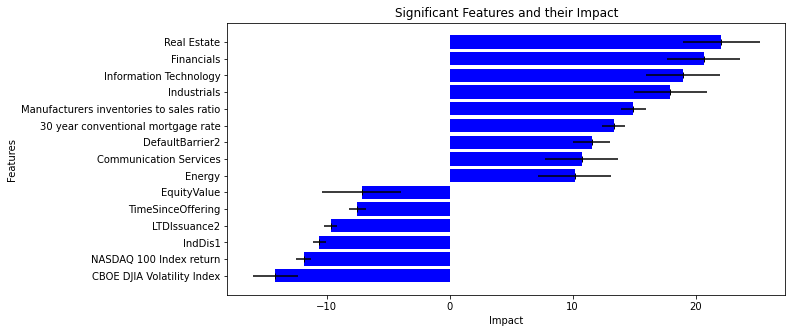


________________________________________________________________
________________________________________________________________
________________________________________________________________

most_insightful


/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.026898629995951995
            Iterations: 437
            Function evaluations: 442
            Gradient evaluations: 437
Features: most_insightful
                           Logit Regression Results                           
Dep. Variable:          sold_after_14   No. Observations:                75494
Model:                          Logit   Df Residuals:                    75459
Method:                           MLE   Df Model:                           34
Date:                Sun, 02 Feb 2025   Pseudo R-squ.:                  0.9146
Time:                        17:34:53   Log-Likelihood:                -2030.7
converged:                       True   LL-Null:                       -23776.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------

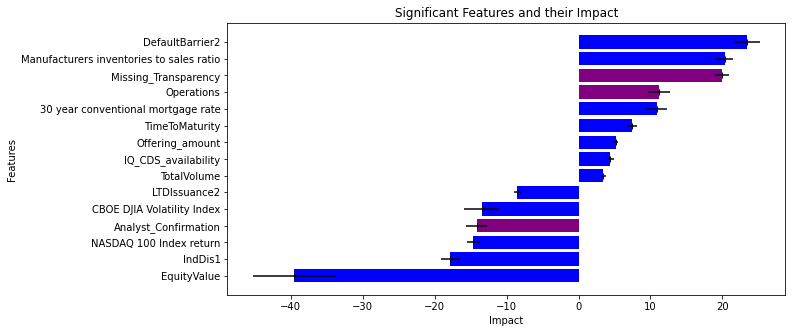


________________________________________________________________
________________________________________________________________
________________________________________________________________

with_emotions


/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.026249168377751608
            Iterations: 399
            Function evaluations: 403
            Gradient evaluations: 399
Features: with_emotions
                           Logit Regression Results                           
Dep. Variable:          sold_after_14   No. Observations:                75494
Model:                          Logit   Df Residuals:                    75457
Method:                           MLE   Df Model:                           36
Date:                Sun, 02 Feb 2025   Pseudo R-squ.:                  0.9167
Time:                        17:34:57   Log-Likelihood:                -1981.7
converged:                       True   LL-Null:                       -23776.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------

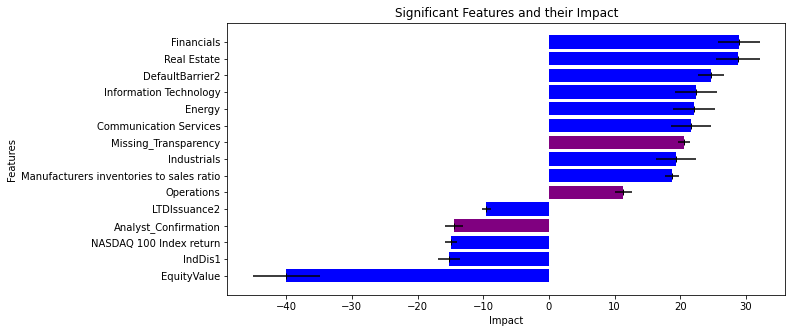


________________________________________________________________
________________________________________________________________
________________________________________________________________

best


/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02538891247338012
            Iterations: 441
            Function evaluations: 445
            Gradient evaluations: 441
Features: best
                           Logit Regression Results                           
Dep. Variable:          sold_after_14   No. Observations:                75494
Model:                          Logit   Df Residuals:                    75453
Method:                           MLE   Df Model:                           40
Date:                Sun, 02 Feb 2025   Pseudo R-squ.:                  0.9194
Time:                        17:35:01   Log-Likelihood:                -1916.7
converged:                       True   LL-Null:                       -23776.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

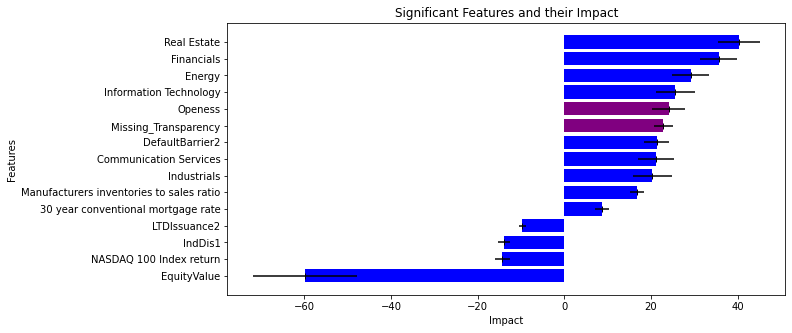


________________________________________________________________
________________________________________________________________
________________________________________________________________

best_composite


/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02911936759376189
            Iterations: 399
            Function evaluations: 404
            Gradient evaluations: 399
Features: best_composite
                           Logit Regression Results                           
Dep. Variable:          sold_after_14   No. Observations:                75494
Model:                          Logit   Df Residuals:                    75459
Method:                           MLE   Df Model:                           34
Date:                Sun, 02 Feb 2025   Pseudo R-squ.:                  0.9075
Time:                        17:35:04   Log-Likelihood:                -2198.3
converged:                       True   LL-Null:                       -23776.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------

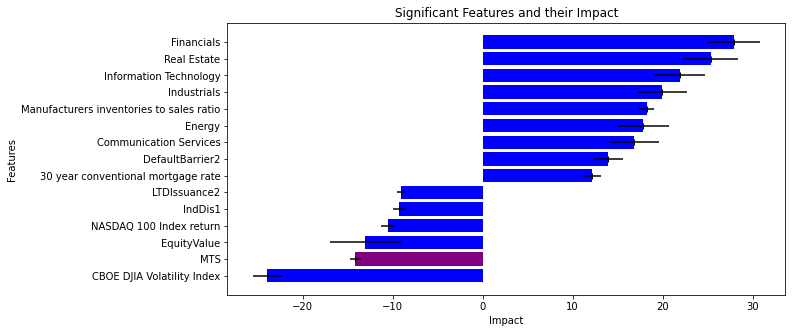

In [116]:
'''SOLD WITHIN 14 DAYS'''
'''LOGIT'''
df = sold_df.copy()

for key in analysis:
    print('')
    print('________________________________________________________________')
    print('________________________________________________________________')
    print('________________________________________________________________')
    print('')
    print(key)
    feature_groups = analysis[key][0]
    best = analysis[key][1]
    if key == "financials":
        final_df = df[['dealer_RR', 'PrimaryDealer', 'sold_after_14']
                            + macro_industry
                            + primary_dealer_features
        ]
    else:
        composite_df = create_loadings(df, feature_groups, best, dealer=True)

        if best:
            # Select the supporting features, nlp_lables, and RR from final_df
            final_df = composite_df[['dealer_RR', 'PrimaryDealer', 'sold_after_14']
                                + macro_industry
                                + primary_dealer_features
                                #####################
                                + ['MTS', 'CAMI', 'ASS']
                                ]
            
        else:
            # Select the supporting features, nlp_lables, and RR from final_df
            final_df = composite_df[['dealer_RR', 'PrimaryDealer', 'sold_after_14']
                                + macro_industry
                                + primary_dealer_features
                                #####################
                                + list(feature_groups.keys())
                                ]
                        
    # reset index
    final_df = final_df.reset_index(drop=True)

    # Replace nan with 0
    final_df.fillna(0, inplace=True)

    # drop single value columns
    final_df = final_df.loc[:, final_df.apply(pd.Series.nunique) != 1]
    
    y = final_df['sold_after_14']
    X = final_df.drop(columns=['sold_after_14'])

    # Add constant for intercept
    X = sm.add_constant(X)
    
    # Fit logistic regression model
    logit_model = sm.Logit(y, X)
    result = logit_model.fit_regularized(method='l1') 
    
    # Print model summary to view p-values, coefficients, etc.
    print(f"Features: {key}")
    print(result.summary())
    
    # Predict probabilities for the test set
    y_pred_prob = result.predict(X)
    
    # Convert probabilities to binary predictions with a threshold of 0.5
    y_pred = (y_pred_prob >= 0.5).astype(int)
    
    # Compute and print evaluation metrics
    accuracy = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_pred_prob)
    precision = np.sum((y == 1) & (y_pred == 1)) / np.sum(y_pred == 1)
    recall = np.sum((y == 1) & (y_pred == 1)) / np.sum(y == 1)
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1Score {f1_score(y, y_pred)}")

    create_colored_chart(result, key)


________________________________________________________________
________________________________________________________________
________________________________________________________________

financials


/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.049955435030487154
            Iterations: 311
            Function evaluations: 316
            Gradient evaluations: 311
Features: financials
                           Logit Regression Results                           
Dep. Variable:          sold_after_30   No. Observations:                75494
Model:                          Logit   Df Residuals:                    75462
Method:                           MLE   Df Model:                           31
Date:                Sun, 02 Feb 2025   Pseudo R-squ.:                  0.8591
Time:                        17:35:10   Log-Likelihood:                -3771.3
converged:                       True   LL-Null:                       -26770.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

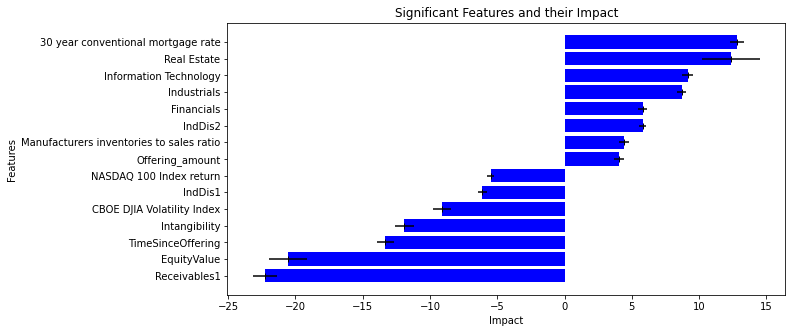


________________________________________________________________
________________________________________________________________
________________________________________________________________

most_insightful


/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.030004064774402903
            Iterations: 337
            Function evaluations: 341
            Gradient evaluations: 337
Features: most_insightful
                           Logit Regression Results                           
Dep. Variable:          sold_after_30   No. Observations:                75494
Model:                          Logit   Df Residuals:                    75459
Method:                           MLE   Df Model:                           34
Date:                Sun, 02 Feb 2025   Pseudo R-squ.:                  0.9154
Time:                        17:35:13   Log-Likelihood:                -2265.1
converged:                       True   LL-Null:                       -26770.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------

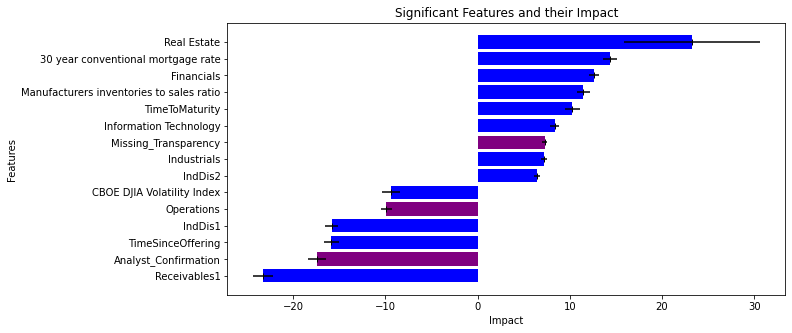


________________________________________________________________
________________________________________________________________
________________________________________________________________

with_emotions


/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.028363023367650043
            Iterations: 359
            Function evaluations: 363
            Gradient evaluations: 359
Features: with_emotions
                           Logit Regression Results                           
Dep. Variable:          sold_after_30   No. Observations:                75494
Model:                          Logit   Df Residuals:                    75457
Method:                           MLE   Df Model:                           36
Date:                Sun, 02 Feb 2025   Pseudo R-squ.:                  0.9200
Time:                        17:35:16   Log-Likelihood:                -2141.2
converged:                       True   LL-Null:                       -26770.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------

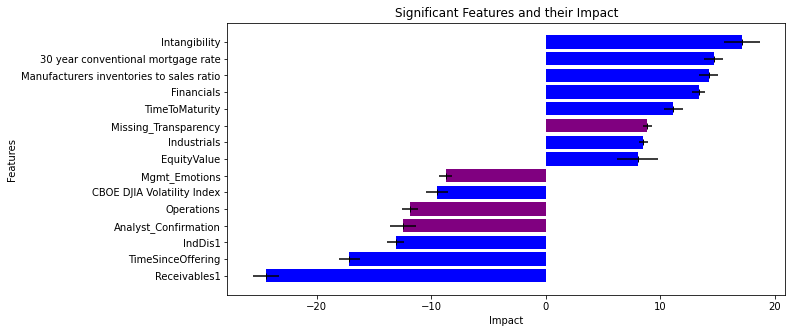


________________________________________________________________
________________________________________________________________
________________________________________________________________

best


/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02697379521349344
            Iterations: 395
            Function evaluations: 400
            Gradient evaluations: 395
Features: best
                           Logit Regression Results                           
Dep. Variable:          sold_after_30   No. Observations:                75494
Model:                          Logit   Df Residuals:                    75453
Method:                           MLE   Df Model:                           40
Date:                Sun, 02 Feb 2025   Pseudo R-squ.:                  0.9239
Time:                        17:35:20   Log-Likelihood:                -2036.4
converged:                       True   LL-Null:                       -26770.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

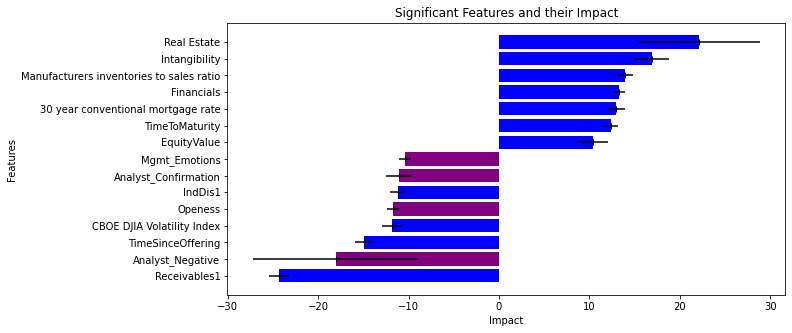


________________________________________________________________
________________________________________________________________
________________________________________________________________

best_composite


/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03139111314097089
            Iterations: 333
            Function evaluations: 337
            Gradient evaluations: 333
Features: best_composite
                           Logit Regression Results                           
Dep. Variable:          sold_after_30   No. Observations:                75494
Model:                          Logit   Df Residuals:                    75459
Method:                           MLE   Df Model:                           34
Date:                Sun, 02 Feb 2025   Pseudo R-squ.:                  0.9115
Time:                        17:35:23   Log-Likelihood:                -2369.8
converged:                       True   LL-Null:                       -26770.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------

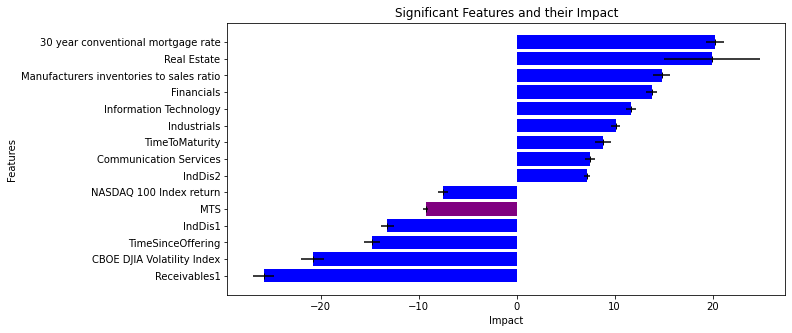

In [117]:
'''SOLD WITHIN 30 DAYS'''
'''LOGIT'''
df = sold_df.copy()

for key in analysis:
    print('')
    print('________________________________________________________________')
    print('________________________________________________________________')
    print('________________________________________________________________')
    print('')
    print(key)
    feature_groups = analysis[key][0]
    best = analysis[key][1]
    if key == "financials":
        final_df = df[['dealer_RR', 'PrimaryDealer', 'sold_after_30']
                            + macro_industry
                            + primary_dealer_features
        ]
    else:
        composite_df = create_loadings(df, feature_groups, best, dealer=True)

        if best:
            # Select the supporting features, nlp_lables, and RR from final_df
            final_df = composite_df[['dealer_RR', 'PrimaryDealer', 'sold_after_30']
                                + macro_industry
                                + primary_dealer_features
                                #####################
                                + ['MTS', 'CAMI', 'ASS']
                                ]
            
        else:
            # Select the supporting features, nlp_lables, and RR from final_df
            final_df = composite_df[['dealer_RR', 'PrimaryDealer', 'sold_after_30']
                                + macro_industry
                                + primary_dealer_features
                                #####################
                                + list(feature_groups.keys())
                                ]
                        
    # reset index
    final_df = final_df.reset_index(drop=True)

    # Replace nan with 0
    final_df.fillna(0, inplace=True)

    # drop single value columns
    final_df = final_df.loc[:, final_df.apply(pd.Series.nunique) != 1]
    
    y = final_df['sold_after_30']
    X = final_df.drop(columns=['sold_after_30'])

    # Add constant for intercept
    X = sm.add_constant(X)
    
    # Fit logistic regression model
    logit_model = sm.Logit(y, X)
    result = logit_model.fit_regularized(method='l1')
    
    # Print model summary to view p-values, coefficients, etc.
    print(f"Features: {key}")
    print(result.summary())
    
    # Predict probabilities for the test set
    y_pred_prob = result.predict(X)
    
    # Convert probabilities to binary predictions with a threshold of 0.5
    y_pred = (y_pred_prob >= 0.5).astype(int)
    
    # Compute and print evaluation metrics
    accuracy = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_pred_prob)
    precision = np.sum((y == 1) & (y_pred == 1)) / np.sum(y_pred == 1)
    recall = np.sum((y == 1) & (y_pred == 1)) / np.sum(y == 1)
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1Score {f1_score(y, y_pred)}")

    # print matrix
    print(f"Confusion Matrix: {confusion_matrix(y, y_pred)}")

    create_colored_chart(result, key)

In [ ]:
'''SOLD WITHIN 30 DAYS'''
'''LINEAR REGRESSION'''
df = sold_df.copy()

for key in analysis:
    print('')
    print('________________________________________________________________')
    print('________________________________________________________________')
    print('________________________________________________________________')
    print('')
    print(key)
    feature_groups = analysis[key][0]
    best = analysis[key][1]
    if key == "financials":
        final_df = df[['dealer_RR', 'PrimaryDealer', 'sold_after_30']
                            + macro_industry
                            + primary_dealer_features
        ]
    else:
        composite_df = create_loadings(df, feature_groups, best, dealer=True)

        if best:
            # Select the supporting features, nlp_lables, and RR from final_df
            final_df = composite_df[['dealer_RR', 'PrimaryDealer', 'sold_after_30']
                                + macro_industry
                                + primary_dealer_features
                                #####################
                                + ['MTS', 'CAMI', 'ASS']
                                ]
            
        else:
            # Select the supporting features, nlp_lables, and RR from final_df
            final_df = composite_df[['dealer_RR', 'PrimaryDealer', 'sold_after_30']
                                + macro_industry
                                + primary_dealer_features
                                #####################
                                + list(feature_groups.keys())
                                ]
                        
    # reset index
    final_df = final_df.reset_index(drop=True)
    # drop duplicates
    #final_df = final_df[final_df['PrimaryDealer'] == 0]

    y = final_df['sold_after_30']
    X = final_df.drop(columns=['sold_after_30'])

    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Print the summary of the model which includes p-values and significance levels
    print(model.summary())

    # Make predictions
    y_pred = model.predict(X)

    # Compute and print evaluation metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")

    create_colored_chart(model, 'New Metrics')

In [ ]:
'''SOLD WITHIN 14 DAYS'''
'''LINEAR REGRESSION'''
df = sold_df.copy()

for key in analysis:
    print('')
    print('________________________________________________________________')
    print('________________________________________________________________')
    print('________________________________________________________________')
    print('')
    print(key)
    feature_groups = analysis[key][0]
    best = analysis[key][1]
    if key == "financials":
        final_df = df[['dealer_RR', 'PrimaryDealer', 'sold_after_14']
                            + macro_industry
                            + primary_dealer_features
        ]
    else:
        composite_df = create_loadings(df, feature_groups, best, dealer=True)

        if best:
            # Select the supporting features, nlp_lables, and RR from final_df
            final_df = composite_df[['dealer_RR', 'PrimaryDealer', 'sold_after_14']
                                + macro_industry
                                + primary_dealer_features
                                #####################
                                + ['MTS', 'CAMI', 'ASS']
                                ]
            
        else:
            # Select the supporting features, nlp_lables, and RR from final_df
            final_df = composite_df[['dealer_RR', 'PrimaryDealer', 'sold_after_14']
                                + macro_industry
                                + primary_dealer_features
                                #####################
                                + list(feature_groups.keys())
                                ]
                        
    # reset index
    final_df = final_df.reset_index(drop=True)
    # drop duplicates
    #final_df = final_df[final_df['PrimaryDealer'] == 0]

    y = final_df['sold_after_14']
    X = final_df.drop(columns=['sold_after_14'])

    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Print the summary of the model which includes p-values and significance levels
    print(model.summary())

    # Make predictions
    y_pred = model.predict(X)

    # Compute and print evaluation metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")

    create_colored_chart(model, 'New Metrics')